In [4]:
import pandas as pd 
import numpy as np 
import math as math
import joblib
from joblib import dump
import os
import time

## DATA TEST

In [2]:
def load_Dataset(baseFile, fold_Number): 
    rnmColData = ['user_id', 'item_id', 'rating', 'timestamp']
    test_File = f"{baseFile}/u{fold_Number}.test"
    test_Data = pd.read_csv(test_File, sep="\t", header=None, names=rnmColData)
    test_Data = test_Data.drop(columns=["timestamp"])
    return test_Data

In [3]:
call_base = "../ml-100k"
testdata = load_Dataset(call_base, 1)
testdata


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3
...,...,...,...
19995,458,648,4
19996,458,1101,4
19997,459,934,3
19998,460,10,3


In [4]:
def GetUniqueUserItemShape(ratingData, fold_num=1):
    max_user = ratingData['user_id'].max()
    unique_user_count = ratingData['user_id'].nunique()
    unique_item_count = ratingData['item_id'].nunique()
    
    result = f"fold {fold_num}, uniq user =  {unique_user_count},uniq item = {unique_item_count},max user = {max_user}"
    return result

# Loop untuk fold 1 sampai 5
for fold in range(1, 6):
    testdata = load_Dataset(call_base, fold)
    output = GetUniqueUserItemShape(testdata, fold)
    print(output)


fold 1, uniq user =  459,uniq item = 1410,max user = 462
fold 2, uniq user =  653,uniq item = 1420,max user = 658
fold 3, uniq user =  869,uniq item = 1423,max user = 877
fold 4, uniq user =  923,uniq item = 1394,max user = 943
fold 5, uniq user =  927,uniq item = 1407,max user = 943


In [5]:
cal = len(pd.unique(testdata["item_id"]))
cal


1407

In [6]:
def uniqDataTest(ratingData):
    unique_users = sorted(ratingData['user_id'].unique())
    unique_items = sorted(ratingData['item_id'].unique())

    # Grup item_id per user_id jadi list item (ground truth)
    grouped = ratingData.groupby('user_id')['item_id'].apply(list)

    # Buat list groundTruth (list item per user) sesuai urutan unique_users
    groundTruth = [grouped[user] for user in unique_users]

    return groundTruth


In [7]:
gt2 = uniqDataTest(testdata)
print(len(gt2))

927


## TOY DATA

In [8]:
# toy data ndcg
groundTruthFold1 = [[1, 2, 3, 4, 11], [1, 12, 4, 7], [4, 11, 12, 32], [2, 3, 5, 10]]
groundTruthFold2 = [[3, 5, 7, 10, 11], [2, 3, 5, 11], [1, 10, 11, 12], [4, 7, 12, 21]]
TopNrekFold1 = [[19, 5, 2, 3, 15], [1,4,6,2], [11, 4, 32, 1], [2, 4, 10, 45]]
TopNrekFold2 = [[2, 3, 4, 15, 5], [3,2,12,42], [1, 12, 2, 22], [4, 7, 12, 22]]


In [9]:
groundTruth1 = [1, 2, 3, 4]
TopNrek1 = [1, 5, 2, 3, 15]

In [10]:
print(TopNrek1[:3])
print(TopNrek1[:3][-1] in groundTruth1)

[1, 5, 2]
True


## DCG


$$  DCG(GT_u, TopN_u, N) = rumusIDCG  \cdot \parallel (TopN_u(n) \in  GT_u) $$

$$ rumusIDCG = \sum_{n=1}^{N} \frac{1}{log_2(1+n)} $$

In [11]:
# dcg per user
def EvaluasiDCG(groundTruth, TopNRekomendasi, N):
    """
    Fungsi untuk menghitung DCG (Discounted Cumulative Gain) untuk rekomendasi item
    """
    rumusIDCG = np.array([(1 / np.log2( 1 + x)) for x in range(1, N+1)])
    
    cekGT = np.array([1 if tp in groundTruth else 0 for tp in TopNRekomendasi[:N]])
    return np.sum(rumusIDCG* cekGT)

In [66]:
import pandas as pd

def dcgN2(groundTruth, TopNrek, max_N):
    dcg_matrix = []  # Menyimpan DCG tiap user untuk N = 1 sampai max_N

    # loop setiap user, dari panjang groundTruth
    for i in range(len(groundTruth)):
        user_dcg = []
        # print(f"\nUser ke-{i+1}:")
        # iterasi N = 1, hingga max_N + 1 untuk dcg
        for N in range(1, max_N + 1):
            dcg_value = EvaluasiDCG(groundTruth[i], TopNrek[i], N)
            # Simpan nilai DCG untuk user ini
            user_dcg.append(dcg_value)
            # print(f"  DCG@{N}: {dcg_value}")
        # Tambahkan DCG untuk user ini ke dalam matrix
        dcg_matrix.append(user_dcg)

    # MemBuat daftar DataFrame
    columns = [f"DCG@{N}" for N in range(1, max_N + 1)]
    df_dcg = pd.DataFrame(dcg_matrix, columns=columns)
    # Menambahkan index untuk setiap user
    df_dcg.index = [f"User-{i+1}" for i in range(len(groundTruth))]

    # Tambahkan rata-rata DCG@N
    avg_row = df_dcg.mean()
    df_dcg.loc["Rata-rata"] = avg_row

    # print("\nDataFrame DCG per user:")
    # print(df_dcg)
    return df_dcg


In [13]:

calDCGN = dcgN2(groundTruthFold1, TopNrekFold1, 4)
calDCGN


User ke-1:

User ke-2:

User ke-3:

User ke-4:


,DCG@1,DCG@2,DCG@3,DCG@4
User-1,0.00,0.000000,0.500000,0.930677
User-2,1.00,1.630930,1.630930,1.630930
User-3,1.00,1.630930,2.130930,2.130930
User-4,1.00,1.000000,1.500000,1.500000
Rata-rata,0.75,1.065465,1.440465,1.548134


In [67]:
dfFold1 = dcgN2(groundTruthFold1, TopNrekFold1, 4)
dfFold2 =  dcgN2(groundTruthFold2, TopNrekFold2, 4)

# hapus baris rata-rata
dfCleanRata1 = dfFold1.drop('Rata-rata')
dfCleanRata2 = dfFold2.drop('Rata-rata')

# gabungkan semua user dari semua fold

df_all = pd.concat([dfCleanRata1, dfCleanRata2])

# hitung rata-rata seluruh fold
rata2fold = df_all.mean().to_frame().T
rata2fold.index = ["rata-rata semua fold"]

dfFinalFold = pd.concat([df_all, rata2fold])
dfFinalFold

,DCG@1,DCG@2,DCG@3,DCG@4
User-1,0.00,0.000000,0.500000,0.930677
User-2,1.00,1.630930,1.630930,1.630930
User-3,1.00,1.630930,2.130930,2.130930
User-4,1.00,1.000000,1.500000,1.500000
User-1,0.00,0.630930,0.630930,0.630930
User-2,1.00,1.630930,1.630930,1.630930
User-3,1.00,1.630930,1.630930,1.630930
User-4,1.00,1.630930,2.130930,2.130930
rata-rata semua fold,0.75,1.223197,1.473197,1.527032


In [15]:
calDCG = EvaluasiDCG(groundTruth1, TopNrek1, 5)
calDCG

1.9306765580733931

## IDCG


$$ IDCG(N) = \sum_{n=1}^{N} \frac{1}{log_2(1+n)}  $$

In [16]:
def IdealDCG(N):
    """
    Fungsi untuk menghitung IDCG (Ideal Discounted Cumulative Gain) untuk rekomendasi item
    """
    rumusIDCG = np.sum(np.array([(1 / np.log2( 1 + x)) for x in range(1, N+1)]))
    # print(rumusIDCG)
    return rumusIDCG

In [17]:
calIdcf = IdealDCG(460)
calIdcf

66.06788640485831

## NDCG

$$ NDCG(GT_u, TopN_u, N) = \frac {DCG(GT_u, TopN_u, N)}{IDCG(N)} $$ 

In [18]:
def EvaluasiNDCG(groundTruth, TopNRekomendasi, N):
    """
    Fungsi untuk menghitung NDCG (Normalized Discounted Cumulative Gain) untuk rekomendasi item
    """
    evaluasiNDCG = EvaluasiDCG(groundTruth, TopNRekomendasi, N) / IdealDCG(N)
    return evaluasiNDCG

In [64]:
def NDCGN(groundTruth, TopNrek, max_N):
    ndcg_matrix = []  # Menyimpan DCG tiap user untuk N = 1 sampai max_N

    for i in range(len(groundTruth)):
        user_ndcg = []
        # print(f"\nUser ke-{i+1}:")
        for N in range(1, max_N + 1):
            ndcg_value = EvaluasiNDCG(groundTruth[i], TopNrek[i], N)
            user_ndcg.append(ndcg_value)
            # print(f"  NDCG@{N}: {ndcg_value}")
        ndcg_matrix.append(user_ndcg)

    # Buat DataFrame
    columns = [f"NDCG@{N}" for N in range(1, max_N + 1)]
    df_ndcg = pd.DataFrame(ndcg_matrix, columns=columns)
    df_ndcg.index = [f"User-{i+1}" for i in range(len(groundTruth))]

    # Tambahkan rata-rata DCG@N
    avg_row = df_ndcg.mean()
    df_ndcg.loc["Rata-rata"] = avg_row

    # print("\nDataFrame DCG per user:")
    # print(df_dcg)

    return df_ndcg


In [65]:
calNDCGN = NDCGN(groundTruthFold1, TopNrekFold1, 4)
calNDCGN

,NDCG@1,NDCG@2,NDCG@3,NDCG@4
User-1,0.00,0.000000,0.234639,0.363318
User-2,1.00,1.000000,0.765361,0.636682
User-3,1.00,1.000000,1.000000,0.831872
User-4,1.00,0.613147,0.703918,0.585570
Rata-rata,0.75,0.653287,0.675980,0.604361


In [70]:
dfFold1 = NDCGN(groundTruthFold1, TopNrekFold1, 4)
dfFold2 =  NDCGN(groundTruthFold2, TopNrekFold2, 4)

# hapus baris rata-rata
dfCleanRata1 = dfFold1.drop('Rata-rata')
dfCleanRata2 = dfFold2.drop('Rata-rata')

# gabungkan semua user dari semua fold

df_all = pd.concat([dfCleanRata1, dfCleanRata2])

# hitung rata-rata seluruh fold
rata2fold = df_all.mean().to_frame().T
rata2fold.index = ["rata-rata semua fold"]

dfFinalFold = pd.concat([df_all, rata2fold])
dfFinalFold

,NDCG@1,NDCG@2,NDCG@3,NDCG@4
User-1,0.00,0.000000,0.234639,0.363318
User-2,1.00,1.000000,0.765361,0.636682
User-3,1.00,1.000000,1.000000,0.831872
User-4,1.00,0.613147,0.703918,0.585570
User-1,0.00,0.386853,0.296082,0.246302
User-2,1.00,1.000000,0.765361,0.636682
User-3,1.00,1.000000,0.765361,0.636682
User-4,1.00,1.000000,1.000000,0.831872
rata-rata semua fold,0.75,0.750000,0.691340,0.596123


In [22]:
calNDCG = EvaluasiNDCG(groundTruth1, TopNrek1, 4)
calNDCG

0.75369761125927

## LOPP TEST REAL DATA

In [23]:
openTopN = joblib.load("../case/topN/Jac/topNUser/1/5_20_0.7.joblib")
# openTopN100 = joblib.load("../case/topN/topN100.joblib")
# jadikan data frame
print((openTopN))

[[1466, 1598, 1499, 1641, 1448, 895, 1366, 1652, 921, 312, 1200, 1188, 407, 1292, 1367, 1644, 912, 1635, 1650, 1649], [1598, 1652, 1292, 1466, 1448, 1499, 1188, 850, 1121, 407, 1641, 317, 131, 319, 49, 653, 510, 518, 123, 514], [1652, 1448, 1292, 1641, 1598, 850, 1466, 1121, 1499, 749, 1188, 173, 18, 1650, 1649, 1635, 912, 1644, 1234, 1638], [1366, 1292, 1652, 1499, 319, 1598, 1448, 1466, 1188, 49, 1641, 849, 1200, 922, 1635, 1649, 1644, 1650, 912, 301], [1466, 1366, 1499, 1652, 1598, 317, 11, 1641, 1188, 1448, 113, 245, 1141, 1628, 197, 1121, 155, 133, 530, 271], [1598, 1466, 1448, 1652, 1499, 1641, 602, 656, 1292, 1121, 1366, 1188, 1367, 1200, 1635, 1649, 1650, 1644, 912, 866], [1466, 1652, 1366, 1188, 1641, 1499, 1367, 1121, 1448, 407, 1598, 113, 479, 88, 6, 168, 1239, 588, 1644, 1650], [1466, 1598, 1499, 1448, 1366, 1121, 312, 1641, 63, 1141, 512, 177, 1292, 1188, 640, 21, 407, 317, 11, 920], [1466, 1292, 1598, 1499, 1448, 1641, 319, 1652, 602, 317, 168, 312, 47, 356, 11, 1121, 136

In [24]:
print(type(openTopN))

<class 'list'>


In [68]:
calNDCGN100 = NDCGN(gt2, openTopN, 20)
calNDCGN100

,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032338
User-5,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-924,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-925,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-926,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
User-927,0.000000,0.000000,0.00000,0.000000,0.00000,0.107789,0.097913,0.090100,0.083725,0.078398,0.131706,0.124717,0.118600,0.113190,0.108362,0.104021,0.100090,0.096509,0.093232,0.090217


In [26]:
max_value = calNDCGN100.max().max()
user_with_max = calNDCGN100.stack().idxmax()  # (row_index, column_name)
print(f'Nilai maksimal DCG: {max_value}')
print(f'Ditemukan di user: {user_with_max[0]}')
print(f'Pada: {user_with_max[1]}')


Nilai maksimal DCG: 1.0
Ditemukan di user: User-146
Pada: NDCG@1


In [69]:
calDCGN2 = dcgN2(gt2, openTopN, 20)
calDCGN2

,DCG@1,DCG@2,DCG@3,DCG@4,DCG@5,DCG@6,DCG@7,DCG@8,DCG@9,DCG@10,DCG@11,DCG@12,DCG@13,DCG@14,DCG@15,DCG@16,DCG@17,DCG@18,DCG@19,DCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.227670
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
User-925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
User-926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
User-927,0.000000,0.000000,0.000000,0.000000,0.000000,0.356207,0.356207,0.356207,0.356207,0.356207,0.635150,0.635150,0.635150,0.63515,0.635150,0.635150,0.635150,0.63515,0.635150,0.635150


## LOOP SEMUA FOLD 

### DCG

In [28]:
def DCGALL(base_input_dir, base_output_dir, dataset_dir, N=20):
    for fold in range(1, 6):
        print(f"\n🔄 Processing Fold {fold}...")

        # Load calTest dan convert ke list ground truth
        testdata = load_Dataset(dataset_dir, fold)
        dataTestUniq = uniqDataTest(testdata)

        fold_input_path = os.path.join(base_input_dir, str(fold))
        fold_output_path = os.path.join(base_output_dir, str(fold))
        os.makedirs(fold_output_path, exist_ok=True)

        # Loop semua file .joblib di folder fold ini
        for filename in os.listdir(fold_input_path):
            if filename.endswith(".joblib"):
                filepath = os.path.join(fold_input_path, filename)

                try:
                    print(f"  ✅ Processing: {filename}")
                    openTopN = joblib.load(filepath)
                    calDCGN = dcgN2(dataTestUniq, openTopN, N)

                    # Simpan hasil DCGN
                    result_name = filename.replace(".joblib", "_dcg.joblib")
                    result_path = os.path.join(fold_output_path, result_name)
                    joblib.dump(calDCGN, result_path)
                    print(f"    💾 Saved to: {result_path}")

                except Exception as e:
                    print(f"  ❌ Error processing {filename}: {e}")

#### JAC

In [29]:
# calProses = DCGALL(
#     "../case/topN/Jac/topNUser", 
#     "../case/DCG/Jac/user", 
#     "../ml-100k",
#     N=20
# )

In [30]:
# calProses = DCGALL(
#     "../case/topN/Jac/topNItem", 
#     "../case/DCG/Jac/item", 
#     "../ml-100k",
#     N=20
# )

#### RJ

In [32]:
# calProsesRJ = DCGALL(
#     "../case/topN/RJ/topNUser", 
#     "../case/DCG/RJ/user", 
#     "../ml-100k",
#     N=20
# )

In [33]:
# calProsesRJ = DCGALL(
#     "../case/topN/RJ/topNItem", 
#     "../case/DCG/RJ/item", 
#     "../ml-100k",
#     N=20
# )

#### HYBRID

In [ ]:
# calProses = DCGALL(
#     "../case/topN/Jac/topNHybrid", 
#     "../case/DCG/Jac/hybrid", 
#     "../ml-100k",
#     N=20
# )

In [34]:
# calProses = DCGALL(
#     "../case/topN/RJ/topNHybrid", 
#     "../case/DCG/RJ/hybrid", 
#     "../ml-100k",
#     N=20
# )

### NDCG

In [35]:
def NDCGNALL(base_input_dir, base_output_dir, dataset_dir, N=20):
    for fold in range(1, 6):
        print(f"\n🔄 Processing Fold {fold}...")

        # Load calTest dan convert ke list ground truth
        testdata = load_Dataset(dataset_dir, fold)
        dataTestUniq = uniqDataTest(testdata)

        fold_input_path = os.path.join(base_input_dir, str(fold))
        fold_output_path = os.path.join(base_output_dir, str(fold))
        os.makedirs(fold_output_path, exist_ok=True)

        # Loop semua file .joblib di folder fold ini
        for filename in os.listdir(fold_input_path):
            if filename.endswith(".joblib"):
                filepath = os.path.join(fold_input_path, filename)

                try:
                    print(f"  ✅ Processing: {filename}")
                    openTopN = joblib.load(filepath)
                    calNDCGN = NDCGN(dataTestUniq, openTopN, N)

                    # Simpan hasil DCGN
                    result_name = filename.replace(".joblib", "_ndcg.joblib")
                    result_path = os.path.join(fold_output_path, result_name)
                    joblib.dump(calNDCGN, result_path)
                    print(f"    💾 Saved to: {result_path}")

                except Exception as e:
                    print(f"  ❌ Error processing {filename}: {e}")

#### JAC

In [36]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNUser", 
#     "../case/NDCG/Jac/user", 
#     "../ml-100k",
#     N=20
# )

In [37]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNItem", 
#     "../case/NDCG/Jac/item", 
#     "../ml-100k",
#     N=20
# )

#### RJ

In [38]:
# calProsesRJ = NDCGNALL(
#     "../case/topN/RJ/topNUser", 
#     "../case/NDCG/RJ/user", 
#     "../ml-100k",
#     N=20
# )

In [39]:
# calProsesRJ = NDCGNALL(
#     "../case/topN/RJ/topNItem", 
#     "../case/NDCG/RJ/item", 
#     "../ml-100k",
#     N=20
# )

#### HYBRID

In [40]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNHybrid", 
#     "../case/NDCG/Jac/hybrid", 
#     "../ml-100k",
#     N=20
# )

In [41]:
# calProses = NDCGNALL(
#     "../case/topN/RJ/topNHybrid", 
#     "../case/NDCG/RJ/hybrid", 
#     "../ml-100k",
#     N=20
# )

#### HYBRID TERBAIK

In [75]:
# calProses = NDCGNALL(
#     "../case/topN/Jac/topNhybridTerbaik", 
#     "../case/NDCG/Jac/hybridTerbaik", 
#     "../ml-100k",
#     N=20
# )

In [90]:
# calProses = NDCGNALL(
#     "../case/topN/RJ/topNhybridTerbaik", 
#     "../case/NDCG/RJ/hybridTerbaik", 
#     "../ml-100k",
#     N=20
# )

## TAHAP FOLD 1

In [42]:
loaduser1 = joblib.load("../case/NDCG/Jac/user/1/10_20_0.7_ndcg.joblib")
print(len(loaduser1))
(loaduser1)

460


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000


In [43]:
loaduser = joblib.load("../case/DCG/Jac/user/1/10_20_0.7_dcg.joblib")
print(len(loaduser))
(loaduser)

460


,DCG@1,DCG@2,DCG@3,DCG@4,DCG@5,DCG@6,DCG@7,DCG@8,DCG@9,DCG@10,DCG@11,DCG@12,DCG@13,DCG@14,DCG@15,DCG@16,DCG@17,DCG@18,DCG@19,DCG@20
User-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-456,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-457,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-458,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
User-459,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [44]:
loaduser1 = joblib.load("../case/NDCG/Jac/user/2/15_20_0.7_ndcg.joblib")
print(len(loaduser1))
(loaduser1)

654


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
User-1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-5,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User-650,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-651,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-652,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
User-653,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [72]:
# values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# # values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# for i in range(len(values)):
#     # print(f"nilai {i+1} = {values[i]}")
#     loaduser = joblib.load(f"../case/NDCG/Jac/user/1/{values[i]}_20_0.7_ndcg.joblib")
#     print(len(loaduser))
#     print(loaduser)

## TAHAP FOLD 2

In [46]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]

all_avg_rows = []  # List untuk simpan baris rata-rata dari tiap file

for val in values:
    filepath = f"../case/NDCG/Jac/user/1/{val}_20_0.7_ndcg.joblib";''
    df = joblib.load(filepath)  # Hasilnya DataFrame

    # Ambil hanya baris 'Rata-rata' dan ubah jadi satu baris Series
    avg_row = df.loc["Rata-rata"]
    avg_row["value"] = val  # Tambahkan kolom info parameter nilai

    all_avg_rows.append(avg_row)

# Gabungkan semua rata-rata jadi DataFrame
final_df = pd.DataFrame(all_avg_rows)

# Atur ulang indeks
final_df.reset_index(drop=True, inplace=True)

# Tampilkan hasil
final_df


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,...,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20,value
0,0.004357,0.004357,0.004868,0.006248,0.007715,0.008527,0.008943,0.009273,0.009696,0.010326,...,0.010973,0.011824,0.012278,0.013056,0.013929,0.014391,0.014655,0.014528,0.015044,5.0
1,0.002179,0.001336,0.002045,0.002800,0.004148,0.006049,0.006892,0.007559,0.008874,0.009418,...,0.010401,0.010746,0.011250,0.011792,0.012280,0.012721,0.012890,0.013488,0.013686,10.0
2,0.002179,0.001336,0.001534,0.002008,0.002602,0.003496,0.006370,0.007078,0.007657,0.008555,...,0.009516,0.009904,0.010148,0.011481,0.011806,0.012431,0.012687,0.012848,0.013349,15.0
3,0.002179,0.001336,0.001022,0.001583,0.003090,0.003462,0.005740,0.007020,0.007603,0.008228,...,0.009462,0.009853,0.010397,0.011162,0.011588,0.011973,0.012480,0.012500,0.012871,18.0
4,0.002179,0.001336,0.001022,0.001583,0.002805,0.003207,0.005109,0.006092,0.006277,0.007819,...,0.009683,0.010170,0.010401,0.010608,0.011318,0.011467,0.011914,0.012471,0.012631,20.0
5,0.002179,0.001336,0.001022,0.001583,0.002805,0.002972,0.004097,0.005682,0.006514,0.007485,...,0.009382,0.009776,0.010424,0.010908,0.010995,0.011567,0.011543,0.012187,0.012638,25.0
6,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004446,0.005134,0.005850,0.007418,...,0.009326,0.009723,0.010572,0.011050,0.011218,0.011288,0.011898,0.012233,0.012401,30.0
7,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004047,0.005114,0.005523,0.007112,...,0.009057,0.010001,0.010440,0.010738,0.011442,0.011422,0.011948,0.012134,0.012235,40.0
8,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.003847,0.004583,0.005338,0.006939,...,0.009237,0.009960,0.010300,0.010697,0.011142,0.011215,0.011593,0.011643,0.012041,50.0
9,0.002179,0.001336,0.001022,0.001583,0.002233,0.002462,0.003434,0.003855,0.004199,0.005180,...,0.007082,0.007269,0.008428,0.008626,0.009328,0.009717,0.010694,0.010775,0.011483,100.0


In [47]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]

all_avg_rows = []  # List untuk simpan baris rata-rata dari tiap file

for val in values:
    filepath = f"../case/NDCG/Jac/user/1/{val}_20_0.7_ndcg.joblib";''
    df = joblib.load(filepath)  # Hasilnya DataFrame

    # Ambil hanya baris 'Rata-rata' dan ubah jadi satu baris Series
    avg_row = df.loc["Rata-rata"]
    avg_row["value"] = val  # Tambahkan kolom info parameter nilai

    all_avg_rows.append(avg_row)

# Gabungkan semua rata-rata jadi DataFrame
final_df = pd.DataFrame(all_avg_rows)

# Atur ulang indeks
final_df.reset_index(drop=True, inplace=True)

# Tampilkan hasil
final_df


,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,...,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20,value
0,0.004357,0.004357,0.004868,0.006248,0.007715,0.008527,0.008943,0.009273,0.009696,0.010326,...,0.010973,0.011824,0.012278,0.013056,0.013929,0.014391,0.014655,0.014528,0.015044,5.0
1,0.002179,0.001336,0.002045,0.002800,0.004148,0.006049,0.006892,0.007559,0.008874,0.009418,...,0.010401,0.010746,0.011250,0.011792,0.012280,0.012721,0.012890,0.013488,0.013686,10.0
2,0.002179,0.001336,0.001534,0.002008,0.002602,0.003496,0.006370,0.007078,0.007657,0.008555,...,0.009516,0.009904,0.010148,0.011481,0.011806,0.012431,0.012687,0.012848,0.013349,15.0
3,0.002179,0.001336,0.001022,0.001583,0.003090,0.003462,0.005740,0.007020,0.007603,0.008228,...,0.009462,0.009853,0.010397,0.011162,0.011588,0.011973,0.012480,0.012500,0.012871,18.0
4,0.002179,0.001336,0.001022,0.001583,0.002805,0.003207,0.005109,0.006092,0.006277,0.007819,...,0.009683,0.010170,0.010401,0.010608,0.011318,0.011467,0.011914,0.012471,0.012631,20.0
5,0.002179,0.001336,0.001022,0.001583,0.002805,0.002972,0.004097,0.005682,0.006514,0.007485,...,0.009382,0.009776,0.010424,0.010908,0.010995,0.011567,0.011543,0.012187,0.012638,25.0
6,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004446,0.005134,0.005850,0.007418,...,0.009326,0.009723,0.010572,0.011050,0.011218,0.011288,0.011898,0.012233,0.012401,30.0
7,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.004047,0.005114,0.005523,0.007112,...,0.009057,0.010001,0.010440,0.010738,0.011442,0.011422,0.011948,0.012134,0.012235,40.0
8,0.002179,0.001336,0.001022,0.001583,0.002233,0.002697,0.003847,0.004583,0.005338,0.006939,...,0.009237,0.009960,0.010300,0.010697,0.011142,0.011215,0.011593,0.011643,0.012041,50.0
9,0.002179,0.001336,0.001022,0.001583,0.002233,0.002462,0.003434,0.003855,0.004199,0.005180,...,0.007082,0.007269,0.008428,0.008626,0.009328,0.009717,0.010694,0.010775,0.011483,100.0


In [87]:
import joblib
import pandas as pd

# Parameter
values1 = 5
values2 = 10
values3 = 1

# Untuk menyimpan hasil rata-rata tiap fold
all_avg_rows = []

# Loop untuk 5 fold
for fold in range(1, 6):
    filepath = f"../case/NDCG/Jac/hybridTerbaik/{fold}/{values1}_{values2}_{values3}_ndcg.joblib"
    df = joblib.load(filepath)
    
    # Ambil baris 'Rata-rata'
    avg_row = df.loc["Rata-rata"].copy()
    
    # Simpan info fold atau id
    avg_row["Fold"] = f"Fold {fold}"
    all_avg_rows.append(avg_row)

# Konversi ke DataFrame
final_df = pd.DataFrame(all_avg_rows)

# Pisahkan kolom angka dari kolom "Fold"
numeric_cols = [col for col in final_df.columns if col.startswith("NDCG@")]
value_cols = final_df[numeric_cols].astype(float)

# Hitung rata-rata per kolom Top-N
mean_row = value_cols.mean().to_dict()
mean_row["Fold"] = "Rata-rata"

# Tambahkan ke DataFrame
final_df = pd.concat([final_df, pd.DataFrame([mean_row])], ignore_index=True)

# Atur ulang kolom agar "Fold" di depan
cols = ["Fold"] + [col for col in final_df.columns if col != "Fold"]
final_df = final_df[cols]

# Tampilkan hasil
final_df


,Fold,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
0,Fold 1,0.021786,0.017572,0.017539,0.016788,0.016872,0.016697,0.016764,0.016643,0.017624,0.017612,0.017727,0.017711,0.017697,0.018083,0.017776,0.018024,0.017672,0.017897,0.017807,0.017936
1,Fold 2,0.022971,0.015269,0.014921,0.013184,0.012861,0.011970,0.011294,0.011493,0.011005,0.011376,0.011958,0.011974,0.012438,0.012849,0.012823,0.012923,0.012955,0.013095,0.012910,0.012938
2,Fold 3,0.012658,0.008207,0.007361,0.006897,0.006445,0.006371,0.006314,0.006545,0.006978,0.007119,0.007440,0.007717,0.008354,0.008655,0.009071,0.009123,0.009257,0.009337,0.009450,0.009702
3,Fold 4,0.007584,0.005069,0.003880,0.003956,0.003437,0.004001,0.004627,0.004776,0.004975,0.005899,0.006686,0.007481,0.008283,0.008350,0.008733,0.009165,0.009310,0.009364,0.009598,0.009813
4,Fold 5,0.001079,0.002748,0.003369,0.003165,0.003174,0.003065,0.003278,0.003361,0.003810,0.004391,0.004824,0.005083,0.005468,0.005809,0.006022,0.006386,0.006593,0.006936,0.007213,0.007468
5,Rata-rata,0.013216,0.009773,0.009414,0.008798,0.008558,0.008421,0.008456,0.008564,0.008878,0.009280,0.009727,0.009993,0.010448,0.010749,0.010885,0.011124,0.011157,0.011326,0.011396,0.011572


In [91]:
import joblib
import pandas as pd

# Parameter
values1 = 5
values2 = 5
values3 = 1

# Untuk menyimpan hasil rata-rata tiap fold
all_avg_rows = []

# Loop untuk 5 fold
for fold in range(1, 6):
    filepath = f"../case/NDCG/RJ/hybridTerbaik/{fold}/{values1}_{values2}_{values3}_ndcg.joblib"
    df = joblib.load(filepath)
    
    # Ambil baris 'Rata-rata'
    avg_row = df.loc["Rata-rata"].copy()
    
    # Simpan info fold atau id
    avg_row["Fold"] = f"Fold {fold}"
    all_avg_rows.append(avg_row)

# Konversi ke DataFrame
final_df = pd.DataFrame(all_avg_rows)

# Pisahkan kolom angka dari kolom "Fold"
numeric_cols = [col for col in final_df.columns if col.startswith("NDCG@")]
value_cols = final_df[numeric_cols].astype(float)

# Hitung rata-rata per kolom Top-N
mean_row = value_cols.mean().to_dict()
mean_row["Fold"] = "Rata-rata"

# Tambahkan ke DataFrame
final_df = pd.concat([final_df, pd.DataFrame([mean_row])], ignore_index=True)

# Atur ulang kolom agar "Fold" di depan
cols = ["Fold"] + [col for col in final_df.columns if col != "Fold"]
final_df = final_df[cols]

# Tampilkan hasil
final_df


,Fold,NDCG@1,NDCG@2,NDCG@3,NDCG@4,NDCG@5,NDCG@6,NDCG@7,NDCG@8,NDCG@9,NDCG@10,NDCG@11,NDCG@12,NDCG@13,NDCG@14,NDCG@15,NDCG@16,NDCG@17,NDCG@18,NDCG@19,NDCG@20
0,Fold 1,0.032680,0.024252,0.024696,0.024206,0.025604,0.025427,0.024894,0.025342,0.025398,0.026416,0.026400,0.027658,0.028225,0.027931,0.027484,0.027692,0.027469,0.028045,0.028128,0.027712
1,Fold 2,0.024502,0.018578,0.017812,0.016877,0.015065,0.014431,0.014793,0.016056,0.016437,0.016366,0.016925,0.017327,0.017529,0.017847,0.018131,0.018202,0.018093,0.018267,0.018219,0.018175
2,Fold 3,0.012658,0.009542,0.008653,0.010681,0.011091,0.010392,0.011232,0.012081,0.013017,0.013434,0.014254,0.014841,0.015185,0.015805,0.015818,0.016337,0.016415,0.016569,0.016749,0.016766
3,Fold 4,0.009751,0.007655,0.007130,0.007389,0.008551,0.008797,0.008686,0.008944,0.009384,0.010097,0.010328,0.011332,0.011520,0.012082,0.012444,0.013075,0.013604,0.013737,0.013933,0.014288
4,Fold 5,0.001079,0.003165,0.003688,0.003431,0.003688,0.004919,0.006049,0.006772,0.006903,0.007356,0.007992,0.008254,0.008749,0.009236,0.009808,0.009977,0.010334,0.010659,0.011213,0.011687
5,Rata-rata,0.016134,0.012638,0.012396,0.012517,0.012800,0.012793,0.013131,0.013839,0.014228,0.014734,0.015180,0.015883,0.016242,0.016580,0.016737,0.017056,0.017183,0.017455,0.017648,0.017725


## TAHAP FOLD 3

In [48]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/Jac/user/{fold}/{val}_20_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)

# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,5,0.015044,0.011636,0.008780,0.009205,0.005789,0.010091,True
1,10,0.013686,0.009776,0.007508,0.008356,0.004517,0.008769,False
2,15,0.013349,0.008787,0.007285,0.007782,0.004077,0.008256,False
3,18,0.012871,0.008799,0.007146,0.007414,0.004036,0.008053,False
4,20,0.012631,0.008515,0.007060,0.007526,0.003845,0.007915,False
5,25,0.012638,0.008850,0.006705,0.007231,0.003835,0.007852,False
6,30,0.012401,0.008299,0.006510,0.007190,0.003898,0.007660,False
7,40,0.012235,0.008317,0.006607,0.006964,0.003602,0.007545,False
8,50,0.012041,0.008084,0.006190,0.006920,0.003494,0.007346,False
9,100,0.011483,0.007216,0.005969,0.006593,0.003314,0.006915,False


In [49]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/user/{fold}/{val}_20_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,5,0.0207,0.0145,0.0122,0.0117,0.0079,0.0134,True
1,10,0.0174,0.0120,0.0093,0.0095,0.0058,0.0108,False
2,15,0.0163,0.0112,0.0086,0.0089,0.0051,0.0100,False
3,18,0.0162,0.0107,0.0079,0.0082,0.0050,0.0096,False
4,20,0.0159,0.0103,0.0078,0.0084,0.0048,0.0094,False
5,25,0.0160,0.0101,0.0072,0.0080,0.0044,0.0091,False
6,30,0.0159,0.0098,0.0069,0.0077,0.0041,0.0089,False
7,40,0.0144,0.0099,0.0072,0.0078,0.0041,0.0087,False
8,50,0.0139,0.0096,0.0073,0.0077,0.0043,0.0086,False
9,100,0.0106,0.0074,0.0060,0.0071,0.0037,0.0070,False


In [50]:
import joblib
import pandas as pd

values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/Jac/hybrid/{fold}/5_10_{val}_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
# max_value = ndcg_df["rata-rata"].max()
# ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata
0,0.0,0.0178,0.0097,0.0073,0.0090,0.0064,0.0100
1,0.1,0.0173,0.0092,0.0073,0.0090,0.0060,0.0098
2,0.2,0.0172,0.0092,0.0075,0.0089,0.0059,0.0097
3,0.3,0.0164,0.0091,0.0077,0.0089,0.0059,0.0096
4,0.4,0.0160,0.0098,0.0078,0.0088,0.0060,0.0097
5,0.5,0.0157,0.0101,0.0083,0.0086,0.0061,0.0098
6,0.6,0.0168,0.0107,0.0085,0.0085,0.0060,0.0101
7,0.7,0.0160,0.0117,0.0090,0.0091,0.0063,0.0104
8,0.8,0.0160,0.0118,0.0095,0.0097,0.0063,0.0107
9,0.9,0.0171,0.0124,0.0095,0.0100,0.0065,0.0111


In [51]:
import joblib
import pandas as pd

values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/hybrid/{fold}/5_5_{val}_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,0.0,0.0177,0.0109,0.0075,0.0102,0.0076,0.0108,False
1,0.1,0.0181,0.0111,0.0079,0.0100,0.0070,0.0108,False
2,0.2,0.0176,0.0111,0.0083,0.0103,0.0070,0.0109,False
3,0.3,0.0173,0.0107,0.0087,0.0106,0.0070,0.0109,False
4,0.4,0.0182,0.0113,0.0096,0.0109,0.0066,0.0113,False
5,0.5,0.0198,0.0118,0.0105,0.0107,0.0069,0.0119,False
6,0.6,0.0211,0.0127,0.0111,0.0114,0.0070,0.0127,False
7,0.7,0.0224,0.0140,0.0124,0.0120,0.0080,0.0138,False
8,0.8,0.0239,0.0151,0.0140,0.0126,0.0092,0.0150,False
9,0.9,0.0262,0.0168,0.0158,0.0127,0.0104,0.0164,False


## ANALISIS NDCG PRESENTASE

In [7]:
def fungsiPrensetase(scoreNdcg1, scoreNdcg2):
    rumusPresentase = ((scoreNdcg1 - scoreNdcg2) / scoreNdcg2) * 100
    # jadikan df
    rumusPresentase = pd.DataFrame(rumusPresentase, columns=["Persentase"])
    return rumusPresentase

In [5]:
# Data NDCG
jaccard = np.array([
    0.013216, 0.009773, 0.009414, 0.008798, 0.008558, 0.008421, 0.008456, 0.008564,
    0.008878, 0.009280, 0.009727, 0.009993, 0.010448, 0.010749, 0.010885, 0.011124,
    0.011157, 0.011326, 0.011396, 0.011572
])

relevant_jaccard = np.array([
    0.016134, 0.012638, 0.012396, 0.012517, 0.012800, 0.012793, 0.013131, 0.013839,
    0.014228, 0.014734, 0.015180, 0.015883, 0.016242, 0.016580, 0.016737, 0.017056,
    0.017183, 0.017455, 0.017648, 0.017725
])


In [8]:
calFungsiPrensetase = fungsiPrensetase(jaccard, relevant_jaccard)

# Buat DataFrame untuk tampilan yang rapi
df = pd.DataFrame({
    "Top@K": range(1, 21),
    "Jaccard": jaccard,
    "Relevant_Jaccard": relevant_jaccard,
    "Persentase_Selisih (%)": calFungsiPrensetase["Persentase"].round(2)
    # mean 

})

rata2 = df["Persentase_Selisih (%)"].mean()
df.loc["Rata-rata"] = ["-", "-", "-",round(rata2, 2)]
# Atur ulang indeks
df


,Top@K,Jaccard,Relevant_Jaccard,Persentase_Selisih (%)
0,1,0.013216,0.016134,-18.09
1,2,0.009773,0.012638,-22.67
2,3,0.009414,0.012396,-24.06
3,4,0.008798,0.012517,-29.71
4,5,0.008558,0.0128,-33.14
5,6,0.008421,0.012793,-34.17
6,7,0.008456,0.013131,-35.60
7,8,0.008564,0.013839,-38.12
8,9,0.008878,0.014228,-37.60
9,10,0.00928,0.014734,-37.02


In [10]:

# Hitung persentase perubahan
calFungsiPrensetase = fungsiPrensetase(relevant_jaccard, jaccard)

# Buat DataFrame untuk tampilan yang rapi
df = pd.DataFrame({
    "Top@K": range(1, 21),
    "Relevant_Jaccard": relevant_jaccard,
    "Jaccard": jaccard,
    "Persentase_Selisih (%)": calFungsiPrensetase["Persentase"].round(2)
})



rata2 = df["Persentase_Selisih (%)"].mean()
df.loc["Rata-rata"] = ["-", "-", "-",round(rata2, 2)]
# Atur ulang indeks
df

,Top@K,Relevant_Jaccard,Jaccard,Persentase_Selisih (%)
0,1,0.016134,0.013216,22.08
1,2,0.012638,0.009773,29.32
2,3,0.012396,0.009414,31.68
3,4,0.012517,0.008798,42.27
4,5,0.0128,0.008558,49.57
5,6,0.012793,0.008421,51.92
6,7,0.013131,0.008456,55.29
7,8,0.013839,0.008564,61.60
8,9,0.014228,0.008878,60.26
9,10,0.014734,0.00928,58.77


## GRAFIK

In [52]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/Jac/item/{fold}/5_{val}_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,5,0.0158,0.0108,0.0092,0.0093,0.0065,0.0103,False
1,10,0.0160,0.0117,0.0090,0.0091,0.0063,0.0104,True
2,15,0.0157,0.0114,0.0087,0.0092,0.0058,0.0102,False
3,18,0.0152,0.0118,0.0089,0.0091,0.0058,0.0102,False
4,20,0.0150,0.0116,0.0088,0.0092,0.0058,0.0101,False
5,25,0.0155,0.0114,0.0087,0.0093,0.0058,0.0101,False
6,30,0.0155,0.0112,0.0087,0.0092,0.0057,0.0101,False
7,40,0.0151,0.0114,0.0087,0.0093,0.0055,0.0100,False
8,50,0.0150,0.0113,0.0087,0.0091,0.0056,0.0099,False
9,100,0.0150,0.0111,0.0087,0.0092,0.0056,0.0099,False


In [53]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/item/{fold}/5_{val}_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,5,0.0224,0.0140,0.0124,0.0120,0.0080,0.0138,True
1,10,0.0209,0.0146,0.0124,0.0111,0.0079,0.0134,False
2,15,0.0208,0.0139,0.0125,0.0114,0.0077,0.0133,False
3,18,0.0208,0.0142,0.0123,0.0115,0.0080,0.0134,False
4,20,0.0207,0.0145,0.0122,0.0117,0.0079,0.0134,False
5,25,0.0211,0.0143,0.0123,0.0113,0.0078,0.0134,False
6,30,0.0208,0.0141,0.0122,0.0112,0.0078,0.0132,False
7,40,0.0210,0.0141,0.0123,0.0113,0.0077,0.0133,False
8,50,0.0208,0.0142,0.0122,0.0113,0.0077,0.0132,False
9,100,0.0213,0.0140,0.0123,0.0112,0.0075,0.0133,False


In [54]:
import joblib
import pandas as pd

values = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
folds = [1, 2, 3, 4, 5]

# Dictionary untuk menyimpan data: key = value, value = list of NDCG@20 dari tiap fold
data = {}

for val in values:
    ndcg_per_fold = []
    for fold in folds:
        filepath = f"../case/NDCG/RJ/item/{fold}/5_{val}_0.7_ndcg.joblib"
        df = joblib.load(filepath)
        ndcg20 = df.loc["Rata-rata", "NDCG@20"]
        ndcg_per_fold.append(ndcg20)
    data[val] = ndcg_per_fold

# Buat DataFrame dari dictionary
ndcg_df = pd.DataFrame.from_dict(data, orient="index", columns=["Fold-1", "Fold-2", "Fold-3", "Fold-4", "Fold-5"])

# ROUND 
ndcg_df = ndcg_df.round(4)
# Hitung rata-rata per baris
ndcg_df["rata-rata"] = ndcg_df.mean(axis=1)
ndcg_df["rata-rata"] = ndcg_df["rata-rata"].round(4)
# Reset index agar 'value' jadi kolom
ndcg_df.reset_index(inplace=True)
ndcg_df.rename(columns={"index": "value"}, inplace=True)
max_value = ndcg_df["rata-rata"].max()
ndcg_df["terbaik"] = ndcg_df["rata-rata"] == max_value

# Tampilkan
(ndcg_df)


,value,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,rata-rata,terbaik
0,5,0.0224,0.0140,0.0124,0.0120,0.0080,0.0138,True
1,10,0.0209,0.0146,0.0124,0.0111,0.0079,0.0134,False
2,15,0.0208,0.0139,0.0125,0.0114,0.0077,0.0133,False
3,18,0.0208,0.0142,0.0123,0.0115,0.0080,0.0134,False
4,20,0.0207,0.0145,0.0122,0.0117,0.0079,0.0134,False
5,25,0.0211,0.0143,0.0123,0.0113,0.0078,0.0134,False
6,30,0.0208,0.0141,0.0122,0.0112,0.0078,0.0132,False
7,40,0.0210,0.0141,0.0123,0.0113,0.0077,0.0133,False
8,50,0.0208,0.0142,0.0122,0.0113,0.0077,0.0132,False
9,100,0.0213,0.0140,0.0123,0.0112,0.0075,0.0133,False


In [55]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker

# # Data yang diberikan
# x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_values = [0.0134, 0.0108, 0.0100, 0.0096, 0.0094, 0.0094, 0.0094, 0.0087, 0.0086, 0.0086, 0.0086]

# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# colors = ['#DEEAF6'] + ['#A9A9A9'] * (len(ndcg_values) - 1) # Hijau muda dan abu-abu tua

# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Tetangga terdekat User ($k_{User}$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('RJ KUser', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.014)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('RJ KUser.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'RJ KUser.png'")

In [56]:
# # Data yang diberikan
# x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_values = [0.0100, 0.0087, 0.0082, 0.0080, 0.0079, 0.0078, 0.0076, 0.0075, 0.0073, 0.0069, 0.0066]

# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# colors = ['#90EE90'] + ['#A9A9A9'] * (len(ndcg_values) - 1) # Hijau muda dan abu-abu tua

# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Tetangga terdekat User ($k_{User}$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('Jaccard KUser', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.011)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('Jaccard KUser.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KUser.png'")

In [57]:
# # Data yang diberikan
# x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# ndcg_values = [0.0103, 0.0104, 0.0102, 0.0102, 0.0101, 0.0101, 0.0101, 0.0100, 0.0099, 0.0099, 0.0099]



# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# max_index = ndcg_values.index(max(ndcg_values))
# colors = ['#90EE90' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Tetangga terdekat Item ($k_{Item}$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('Jaccard KItem', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.011)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('Jaccard KItem.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'Jaccard KItem.png'")

In [58]:
# # Data yang diberikan
# x_labels_numeric = [5, 10, 15, 18, 20, 25, 30, 40, 50, 100, 200]
# # ndcg_values = [
# #     0.01028,  # 5
# #     0.01000,  # 10
# #     0.00984,  # 15
# #     0.00990,  # 18
# #     0.00972,  # 20
# #     0.00972,  # 25
# #     0.00960,  # 30
# #     0.00978,  # 40
# #     0.00970,  # 50
# #     0.00998,  # 100
# #     0.00988   # 200
# # ]

# ndcg_values = [0.0138, 0.0134, 0.0133, 0.0134, 0.0134, 0.0134, 0.0132, 0.00978, 0.0132, 0.0133, 0.0133]




# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# max_index = ndcg_values.index(max(ndcg_values))
# colors = ['#DEEAF6' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Tetangga terdekat Item ($k_{Item}$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('RJ KItem', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.015)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('RJ KItem.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'RJ KItem.png'")

In [59]:
# # Data yang diberikan
# x_labels_numeric = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# ndcg_values = [0.0108, 0.0108, 0.0109, 0.0109, 0.0113, 0.0119, 0.0127, 0.0138, 0.0150, 0.0164, 0.0177]




# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# max_index = ndcg_values.index(max(ndcg_values))
# colors = ['#FFF2CC' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Bobot Hybrid RJ ($\gamma$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('Bobot Hybrid', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.0185)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('Bobot Hybrid RJ.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid RJ.png'")

In [60]:
# # Data yang diberikan
# x_labels_numeric = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# ndcg_values = [0.0100, 0.0098, 0.0097, 0.0096, 0.0097, 0.0098, 0.0101, 0.0104, 0.0107, 0.0111, 0.0116]



# # Mengubah label x menjadi string untuk diagram batang kategorikal
# x_labels_str = [str(x) for x in x_labels_numeric]

# # Menentukan warna untuk setiap batang
# max_index = ndcg_values.index(max(ndcg_values))
# colors = ['#FBE4D5' if i == max_index else '#A9A9A9' for i in range(len(ndcg_values))]


# # Membuat diagram batang
# plt.figure(figsize=(12, 7)) # Ukuran gambar bisa disesuaikan
# bars = plt.bar(x_labels_str, ndcg_values, color=colors)

# # Menambahkan label pada sumbu x dan y
# plt.xlabel('Bobot Hybrid Jac ($\gamma$)', fontsize=12)
# plt.ylabel('$NDCG@20$', fontsize=12)

# # Menambahkan judul diagram (opsional, tapi disarankan)
# plt.title('Bobot Hybrid', fontsize=14)

# # Mengatur batas sumbu y agar sesuai dengan gambar contoh (0 hingga 0.018)
# plt.ylim(0, 0.0125)

# # Mengatur format angka pada sumbu y
# formatter = mticker.FormatStrFormatter('%.7f')
# plt.gca().yaxis.set_major_formatter(formatter)

# # Menambahkan grid untuk memudahkan pembacaan (opsional)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Memastikan semua label terbaca dan tidak tumpang tindih
# plt.xticks(rotation=0, ha="right") # Rotasi label sumbu x jika perlu
# plt.tight_layout() # Menyesuaikan layout agar semua elemen pas

# # Menyimpan gambar
# plt.savefig('Bobot Hybrid Jac.png')

# # Menampilkan diagram
# plt.show()

# print("Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Jac.png'")

## GRAFIK TERBAIK

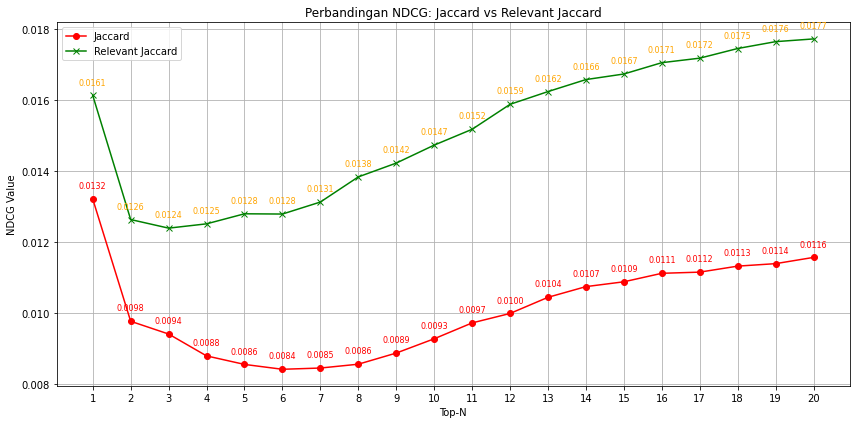

Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Terbaik.png'


In [97]:
import matplotlib.pyplot as plt

# Data NDCG
jaccard = [
    0.013216, 0.009773, 0.009414, 0.008798, 0.008558, 0.008421, 0.008456, 0.008564,
    0.008878, 0.009280, 0.009727, 0.009993, 0.010448, 0.010749, 0.010885, 0.011124,
    0.011157, 0.011326, 0.011396, 0.011572
]

relevant_jaccard = [
    0.016134, 0.012638, 0.012396, 0.012517, 0.012800, 0.012793, 0.013131, 0.013839,
    0.014228, 0.014734, 0.015180, 0.015883, 0.016242, 0.016580, 0.016737, 0.017056,
    0.017183, 0.017455, 0.017648, 0.017725
]

top_k = list(range(1, 21))

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(top_k, jaccard, marker='o', color='red', label='Jaccard')
plt.plot(top_k, relevant_jaccard, marker='x', color='green', label='Relevant Jaccard')

# Tambahkan nilai di setiap titik
for i in range(20):
    plt.text(top_k[i], jaccard[i] + 0.0003, f"{jaccard[i]:.4f}", color='red', ha='center', fontsize=8)
    plt.text(top_k[i], relevant_jaccard[i] + 0.0003, f"{relevant_jaccard[i]:.4f}", color='orange', ha='center', fontsize=8)

# Konfigurasi grafik
plt.xticks(top_k)
plt.xlabel("Top-N")
plt.ylabel("NDCG Value")
plt.title("Perbandingan NDCG: Jaccard vs Relevant Jaccard")
plt.legend()
plt.grid(True)
plt.tight_layout()
# Menyimpan gambar
plt.savefig(f'../eda_Img/Bobot Hybrid Terbaik.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'Bobot Hybrid Terbaik.png'")


## GRAFIK PERSENTASE

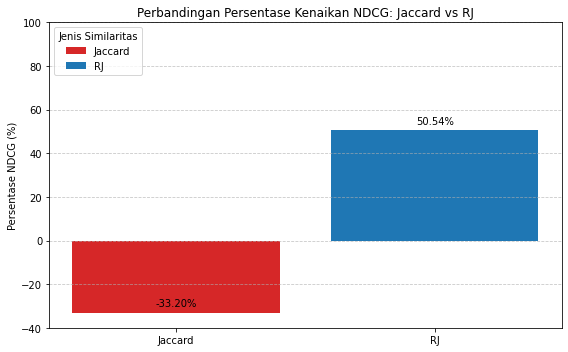

Diagram batang telah dibuat dan disimpan sebagai 'Persentase Kenaikan NDCG.png'


In [45]:
import matplotlib.pyplot as plt

# Ukuran grafik
fig, ax = plt.subplots(figsize=(8, 5))

# Data
similaritas = ['Jaccard', 'RJ']
counts = [-33.20, 50.54]  # Dalam persen
bar_colors = ['tab:red', 'tab:blue']

# Plot batang satu per satu dengan warna sesuai
for i in range(len(similaritas)):
    ax.bar(similaritas[i], counts[i], label=similaritas[i], color=bar_colors[i])

# Label dan judul
ax.set_ylabel('Persentase NDCG (%)')
ax.set_title('Perbandingan Persentase Kenaikan NDCG: Jaccard vs RJ')

# Atur rentang Y axis
ax.set_ylim(-40, 100)

# Tampilkan nilai di atas batang
for i in range(len(similaritas)):
    ax.text(similaritas[i], counts[i] + 2, f'{counts[i]:.2f}%', ha='center', va='bottom', fontsize=10)

# Tambahkan grid horizontal bergaya kotak-kotak
# plt.grid(True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Legenda
ax.legend(title='Jenis Similaritas', loc='upper left')

plt.tight_layout()
plt.savefig(f'../eda_Img/Persentase Kenaikan NDCG.png')

# Menampilkan diagram
plt.show()

print("Diagram batang telah dibuat dan disimpan sebagai 'Persentase Kenaikan NDCG.png'")
